In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [7]:
import sys
sys.path.append("..")

In [128]:
import arviz as az
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import base64
from PIL import Image
from io import BytesIO
from IPython.display import HTML

from coordination.model.brain_model import BrainPosteriorSamples
from coordination.model.vocalic_model import VocalicModel

In [168]:
def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((300, 300), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/png;base64,{image_base64(im)}">'

def get_inference_results_dict(evidence_path: str, inferences_dir: str):
    evidence_df = pd.read_csv(evidence_path, index_col=0)
    results_dict = {"evidence_df": evidence_df, "idata": {}}
    for experiment_id in evidence_df["experiment_id"].unique():
        with open(f"{inferences_dir}/{experiment_id}/inference_data.pkl", "rb") as f:
            idata = pickle.load(f)
        
        results_dict["idata"][experiment_id] = idata
    
    return results_dict    

def generate_thumbnail_report(evidence_path: str, inferences_dir: str, baseline_task: bool):
    results_dict = get_inference_results_dict(evidence_path, inferences_dir)
    with open(f"{inferences_dir}/execution_params.json", "r") as f:
        execution_params = json.load(f)    
    model = execution_params["model"]
    
    if baseline_task:
        report_columns = [
            "experiment_id",
            "team_score",
            "ai_score",
            "diff_score",
            "c_mean",
            "c_var",
            "c_25p",
            "c_50p",
            "c_75p",
            "c_95p",
            "c_99p",
            "c_1t",
            "c_2t",
            "c_3t",
            "c_4t",
            "c_5t",
            "plot"
        ]
    else:
        report_columns = [
            "experiment_id",
            "team_score",
            "c_mean",
            "c_var",
            "c_25p",
            "c_50p",
            "c_75p",
            "c_95p",
            "c_99p",
            "c_1t",
            "c_2t",
            "c_3t",
            "c_4t",
            "c_5t",
            "plot"
        ]
    
    report_data = []
    for experiment_id, idata in results_dict["idata"].items():    
        experiment_evidence_df = results_dict["evidence_df"][results_dict["evidence_df"]["experiment_id"] == experiment_id]
        
        if model == "brain":
            posterior_samples = BrainPosteriorSamples.from_inference_data(idata)                        
        
        if baseline_task:
            score_entries = [
                experiment_evidence_df["team_score"].values[0],
                experiment_evidence_df["ai_score"].values[0],
                (experiment_evidence_df["team_score"] - experiment_evidence_df["ai_score"]).values[0]
            ]
        else:
            score_entries = [
                experiment_evidence_df["team_score"].values[0]
            ]

        coordination = posterior_samples.coordination.mean(dim=["chain", "draw"]).to_numpy()
        report_entry = [
            experiment_id,
            *score_entries,
            coordination.mean(),
            coordination.var(),
            np.quantile(coordination, .25),
            np.quantile(coordination, .50),
            np.quantile(coordination, .75),
            np.quantile(coordination, .95),
            np.quantile(coordination, .99),
            *list(map(np.mean, np.array_split(coordination, 5))),
            f"{inferences_dir}/{experiment_id}/plots/posterior/coordination.png"
        ]
        
        report_data.append(report_entry)
    
    report_df = pd.DataFrame(data=report_data, columns=report_columns)
    
    return report_df

,experiment_id,team_score,ai_score,diff_score,c_mean,c_var,c_25p,c_50p,c_75p,c_95p,c_99p,c_1t,c_2t,c_3t,c_4t,c_5t,plot
3,exp_2022_10_18_10,10,16,-6,0.044557,4.278322e-03,0.007546,0.017160,0.039900,0.185381,0.283656,0.044393,0.084724,0.054214,0.030885,0.008571,
6,exp_2022_11_14_12,7,11,-4,0.045525,3.208156e-03,0.008541,0.023717,0.054440,0.160614,0.258196,0.029485,0.034140,0.066975,0.062865,0.034159,
8,exp_2022_11_18_10,11,13,-2,0.003510,2.149375e-04,0.000175,0.000345,0.000908,0.014163,0.075190,0.010667,0.002371,0.000814,0.000256,0.003445,
0,exp_2022_10_14_10,11,11,0,0.031383,1.216689e-03,0.007104,0.017285,0.045844,0.100159,0.146818,0.056210,0.013356,0.038611,0.015306,0.033431,
4,exp_2022_11_22_10,5,4,1,0.027886,9.077352e-04,0.006843,0.016098,0.035907,0.093056,0.125110,0.034132,0.018813,0.014532,0.048637,0.023319,
7,exp_2022_11_08_11,10,5,5,0.043998,2.709118e-03,0.011547,0.024674,0.062790,0.122615,0.211234,0.046503,0.015849,0.045894,0.071963,0.039782,
1,exp_2022_10_31_10,16,9,7,0.000039,6.982793e-08,0.000005,0.000007,0.000010,0.000021,0.000653,0.000164,0.000008,0.000007,0.000007,0.000009,
5,exp_2022_10_21_15,13,6,7,0.032612,1.634348e-03,0.009187,0.021363,0.042125,0.101178,0.207701,0.034929,0.015412,0.033030,0.032277,0.047414,
2,exp_2022_11_10_10,11,2,9,0.044728,3.355980e-03,0.007275,0.019435,0.065837,0.155092,0.276646,0.084551,0.029917,0.014767,0.043513,0.050891,
9,exp_2022_11_15_13,16,5,11,0.046222,3.270190e-03,0.006564,0.019371,0.070411,0.158578,0.240671,0.070435,0.012616,0.062253,0.031092,0.054714,

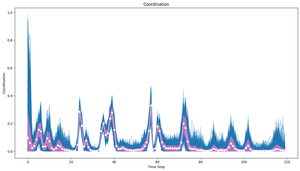
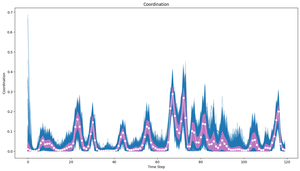
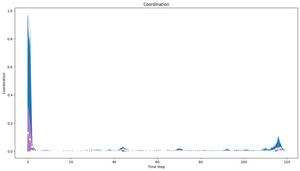
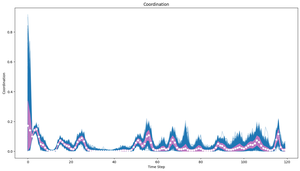
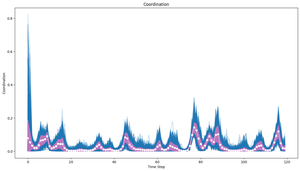
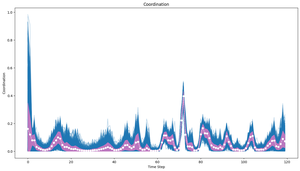
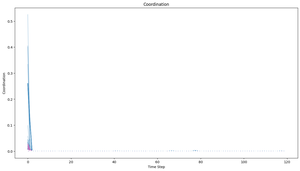
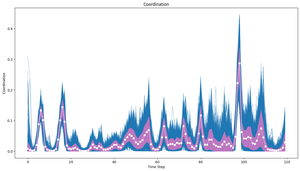
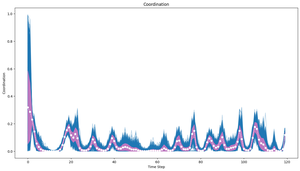
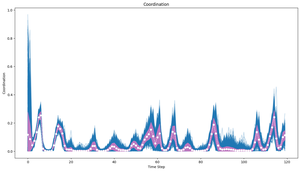

In [169]:
pd.set_option('display.max_colwidth', None)
report_df = generate_thumbnail_report(
    evidence_path="/Users/paulosoares/data/publication_2023/langlab_baseline_task/datasets/cooperative_ping_pong_1_hz_coord_1_hz_brain.csv",
    inferences_dir="/Users/paulosoares/data/publication_2023/langlab_baseline_task/inferences/brain/2023.02.27--15.30.21/",
    baseline_task=True
)
report_df = report_df.sort_values("diff_score")
HTML(report_df.to_html(formatters={'plot': image_formatter}, escape=False))

In [171]:
report_df.plot(["c_1t", "c_2t"], ["c_1t", "c_2t"])

ValueError: x must be a label or position

<Axes: xlabel='c_25p', ylabel='team_score'>

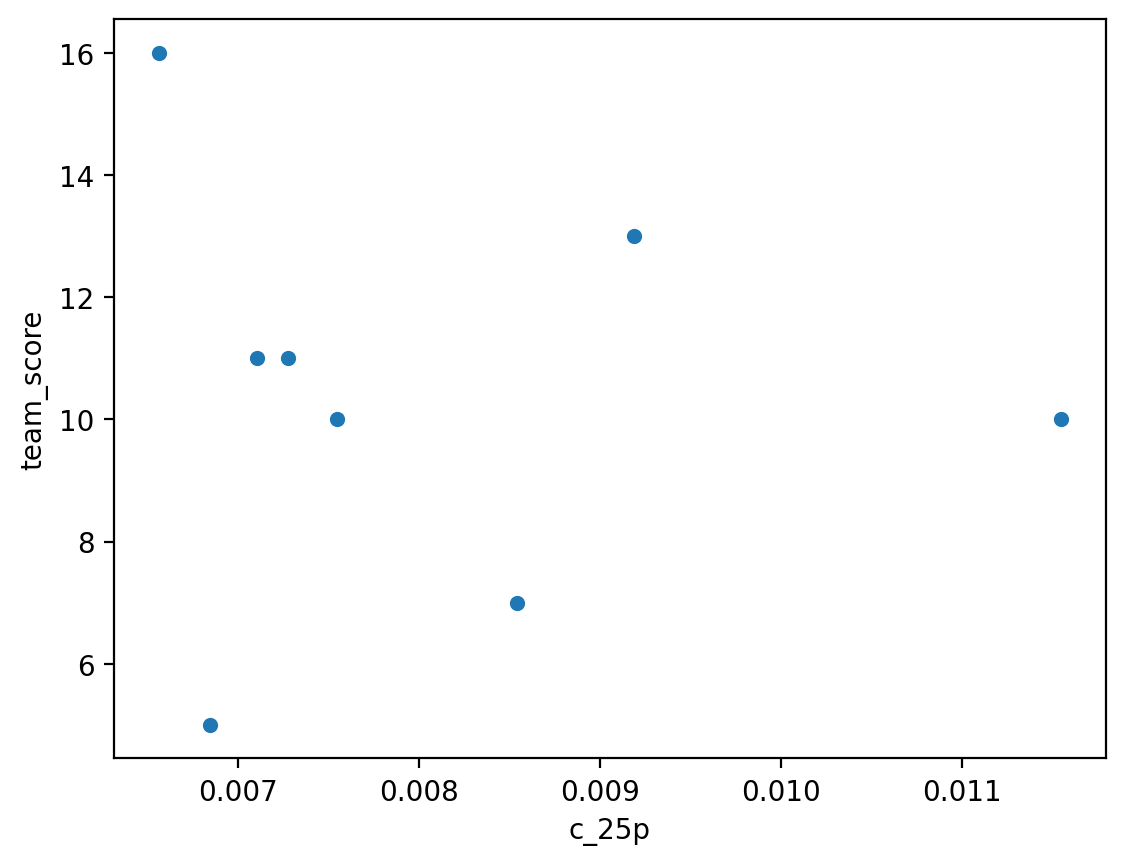

In [165]:
report_df.drop([1,8]).plot.scatter("c_25p", "team_score")